# Properties Analysis - Document Check Results
## Analyzing Pass/Fail Rates by Nationality, Document Type, Gender, and Issuing Country

This notebook extracts and analyzes the `properties` column (JSON data) to understand:
- Which nationalities have highest/lowest pass rates
- Which document types perform best/worst
- Gender-based pass rate differences
- Issuing country patterns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import ast
import json
import warnings
warnings.filterwarnings('ignore')

# Load the Document Check dataset
doc_check_df = pd.read_csv('Data/Document-check-report.csv')

# Convert created_at to datetime
doc_check_df['created_at'] = pd.to_datetime(doc_check_df['created_at'])
doc_check_df['year_month'] = doc_check_df['created_at'].dt.to_period('M')

print(f"📊 Total Records: {len(doc_check_df):,}")
print(f"📅 Date Range: {doc_check_df['created_at'].min().date()} to {doc_check_df['created_at'].max().date()}")
print(f"\n📋 Result Distribution:")
print(doc_check_df['result'].value_counts())

📊 Total Records: 176,404
📅 Date Range: 2021-05-23 to 2021-10-31

📋 Result Distribution:
result
clear       132402
consider     44002
Name: count, dtype: int64


## 1. Extract Properties from JSON Column

In [2]:
# Function to safely parse the properties JSON/dict string
def parse_properties(prop_str):
    """Parse properties string to dictionary"""
    try:
        if pd.isna(prop_str) or prop_str == '{}':
            return {}
        # Try ast.literal_eval first (handles Python dict format)
        return ast.literal_eval(prop_str)
    except:
        try:
            # Try JSON parsing
            return json.loads(prop_str.replace("'", '"'))
        except:
            return {}

# Parse properties column
doc_check_df['properties_parsed'] = doc_check_df['properties'].apply(parse_properties)

# Extract individual fields from properties
doc_check_df['nationality'] = doc_check_df['properties_parsed'].apply(lambda x: x.get('nationality', 'Unknown'))
doc_check_df['document_type'] = doc_check_df['properties_parsed'].apply(lambda x: x.get('document_type', 'Unknown'))
doc_check_df['gender'] = doc_check_df['properties_parsed'].apply(lambda x: x.get('gender', 'Unknown'))
doc_check_df['issuing_country'] = doc_check_df['properties_parsed'].apply(lambda x: x.get('issuing_country', 'Unknown'))

print("✅ Properties extracted successfully!")
print(f"\n📊 Unique Values:")
print(f"   Nationalities: {doc_check_df['nationality'].nunique()}")
print(f"   Document Types: {doc_check_df['document_type'].nunique()}")
print(f"   Genders: {doc_check_df['gender'].nunique()}")
print(f"   Issuing Countries: {doc_check_df['issuing_country'].nunique()}")

✅ Properties extracted successfully!

📊 Unique Values:
   Nationalities: 209
   Document Types: 9
   Genders: 6
   Issuing Countries: 169


In [3]:
# Check distribution of extracted properties
print("=" * 70)
print("DISTRIBUTION OF EXTRACTED PROPERTIES")
print("=" * 70)

print("\n📌 Document Types:")
print(doc_check_df['document_type'].value_counts())

print("\n📌 Gender:")
print(doc_check_df['gender'].value_counts())

print("\n📌 Top 15 Nationalities:")
print(doc_check_df['nationality'].value_counts().head(15))

print("\n📌 Top 15 Issuing Countries:")
print(doc_check_df['issuing_country'].value_counts().head(15))

DISTRIBUTION OF EXTRACTED PROPERTIES

📌 Document Types:
document_type
national_identity_card    54613
driving_licence           50492
passport                  42228
Unknown                   26106
residence_permit           2929
work_permit                  17
voter_id                     11
tax_id                        7
birth_certificate             1
Name: count, dtype: int64

📌 Gender:
gender
Male       78397
Unknown    55836
Female     41536
8              3
MALE           1
FEMALE         1
Name: count, dtype: int64

📌 Top 15 Nationalities:
nationality
Unknown    97913
GBR        12652
ESP         7763
LTU         7569
FRA         6689
POL         6143
IRL         6087
PRT         4456
DEU         3142
ITA         2140
CHE         1848
ROU         1654
NLD         1217
BEL         1188
HUN         1071
Name: count, dtype: int64

📌 Top 15 Issuing Countries:
issuing_country
GBR        39681
Unknown    26103
FRA        23522
LTU        12975
ESP         9464
IRL         9232
POL  

## 2. Pass Rate Analysis by Document Type

PASS RATE BY DOCUMENT TYPE
         document_type  total  clear  consider  pass_rate  fail_rate
national_identity_card  54613  49745      4868  91.086371   8.913629
      residence_permit   2929   2620       309  89.450324  10.549676
       driving_licence  50492  44865      5627  88.855660  11.144340
              passport  42228  35134      7094  83.200720  16.799280
               Unknown  26106      3     26103   0.011492  99.988508


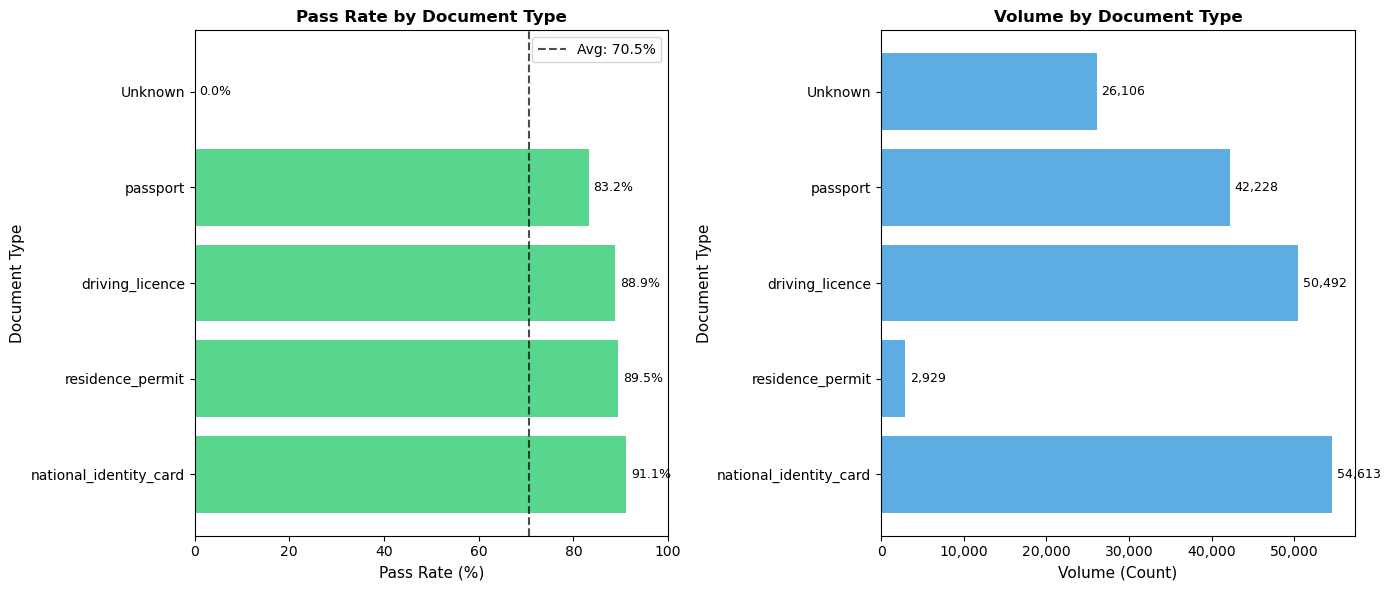

✅ Chart saved as 'pass_rate_by_document_type.png'


In [4]:
# Function to calculate pass rate statistics
def calculate_pass_rate(df, group_col, min_samples=100):
    """Calculate pass rate grouped by a column"""
    stats = df.groupby(group_col).agg(
        total=('result', 'count'),
        clear=('result', lambda x: (x == 'clear').sum()),
        consider=('result', lambda x: (x == 'consider').sum())
    ).reset_index()
    
    stats['pass_rate'] = (stats['clear'] / stats['total']) * 100
    stats['fail_rate'] = (stats['consider'] / stats['total']) * 100
    
    # Filter by minimum samples
    stats = stats[stats['total'] >= min_samples].sort_values('pass_rate', ascending=False)
    
    return stats

# Document Type Analysis
doc_type_stats = calculate_pass_rate(doc_check_df, 'document_type', min_samples=50)

print("=" * 80)
print("PASS RATE BY DOCUMENT TYPE")
print("=" * 80)
print(doc_type_stats.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of pass rates
ax1 = axes[0]
colors = ['#2ecc71' if x >= 80 else '#f39c12' if x >= 60 else '#e74c3c' for x in doc_type_stats['pass_rate']]
bars = ax1.barh(doc_type_stats['document_type'], doc_type_stats['pass_rate'], color=colors, alpha=0.8)
ax1.set_xlabel('Pass Rate (%)', fontsize=11)
ax1.set_ylabel('Document Type', fontsize=11)
ax1.set_title('Pass Rate by Document Type', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.axvline(x=doc_type_stats['pass_rate'].mean(), color='black', linestyle='--', alpha=0.7, label=f"Avg: {doc_type_stats['pass_rate'].mean():.1f}%")
for bar, rate in zip(bars, doc_type_stats['pass_rate']):
    ax1.text(rate + 1, bar.get_y() + bar.get_height()/2, f'{rate:.1f}%', va='center', fontsize=9)
ax1.legend()

# Volume by document type
ax2 = axes[1]
ax2.barh(doc_type_stats['document_type'], doc_type_stats['total'], color='#3498db', alpha=0.8)
ax2.set_xlabel('Volume (Count)', fontsize=11)
ax2.set_ylabel('Document Type', fontsize=11)
ax2.set_title('Volume by Document Type', fontsize=12, fontweight='bold')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
for i, (doc, count) in enumerate(zip(doc_type_stats['document_type'], doc_type_stats['total'])):
    ax2.text(count + max(doc_type_stats['total'])*0.01, i, f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('pass_rate_by_document_type.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'pass_rate_by_document_type.png'")

## 3. Pass Rate Analysis by Gender

PASS RATE BY GENDER
 gender  total  clear  consider  pass_rate  fail_rate
 Female  41536  36336      5200  87.480740  12.519260
   Male  78397  68214     10183  87.010983  12.989017
Unknown  55836  27376     28460  49.029300  50.970700


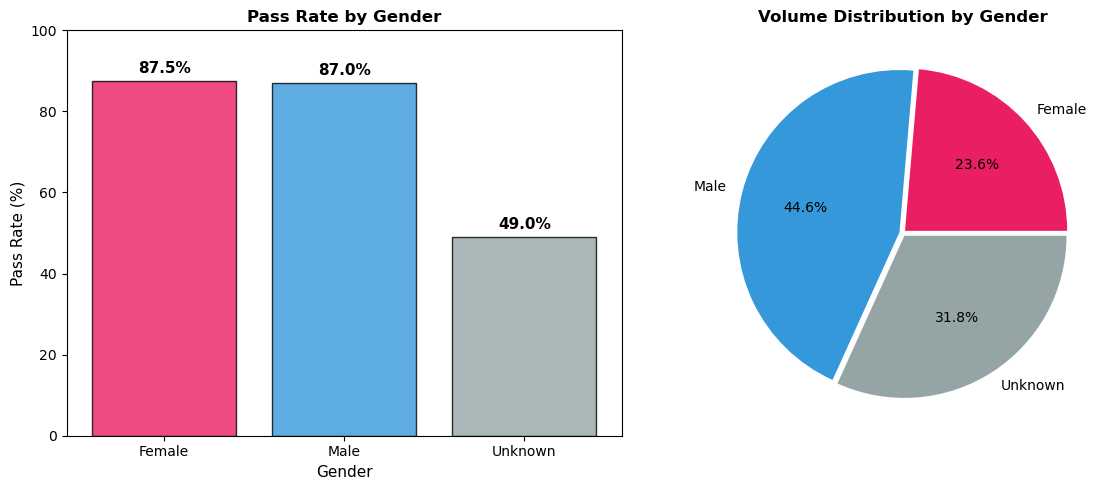

✅ Chart saved as 'pass_rate_by_gender.png'


In [5]:
# Gender Analysis
gender_stats = calculate_pass_rate(doc_check_df, 'gender', min_samples=10)

print("=" * 80)
print("PASS RATE BY GENDER")
print("=" * 80)
print(gender_stats.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pass rate by gender
ax1 = axes[0]
colors = ['#3498db' if g == 'Male' else '#e91e63' if g == 'Female' else '#95a5a6' for g in gender_stats['gender']]
bars = ax1.bar(gender_stats['gender'], gender_stats['pass_rate'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Gender', fontsize=11)
ax1.set_ylabel('Pass Rate (%)', fontsize=11)
ax1.set_title('Pass Rate by Gender', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 100)
for bar, rate in zip(bars, gender_stats['pass_rate']):
    ax1.text(bar.get_x() + bar.get_width()/2, rate + 2, f'{rate:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Volume by gender (pie chart)
ax2 = axes[1]
colors_pie = ['#3498db' if g == 'Male' else '#e91e63' if g == 'Female' else '#95a5a6' for g in gender_stats['gender']]
wedges, texts, autotexts = ax2.pie(gender_stats['total'], labels=gender_stats['gender'], autopct='%1.1f%%', 
                                     colors=colors_pie, explode=[0.02]*len(gender_stats))
ax2.set_title('Volume Distribution by Gender', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('pass_rate_by_gender.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'pass_rate_by_gender.png'")

## 4. Pass Rate Analysis by Nationality (Top & Bottom)

PASS RATE BY NATIONALITY (min 100 samples)

🏆 TOP 10 HIGHEST PASS RATES:
nationality  total  clear  consider  pass_rate  fail_rate
        MYS    180    171         9  95.000000   5.000000
        SVN    680    645        35  94.852941   5.147059
        CYP    259    245        14  94.594595   5.405405
        HRV    327    305        22  93.272171   6.727829
        CHE   1848   1719       129  93.019481   6.980519
        KOR    117    108         9  92.307692   7.692308
        NZL    335    309        26  92.238806   7.761194
        USA    453    416        37  91.832230   8.167770
        MLT    520    477        43  91.730769   8.269231
        RUS    461    422        39  91.540130   8.459870

⚠️ BOTTOM 10 LOWEST PASS RATES:
nationality  total  clear  consider  pass_rate  fail_rate
        GBR  12652  10506      2146  83.038255  16.961745
        NOR    129    107        22  82.945736  17.054264
        FRA   6689   5536      1153  82.762745  17.237255
        IRL   6087   501

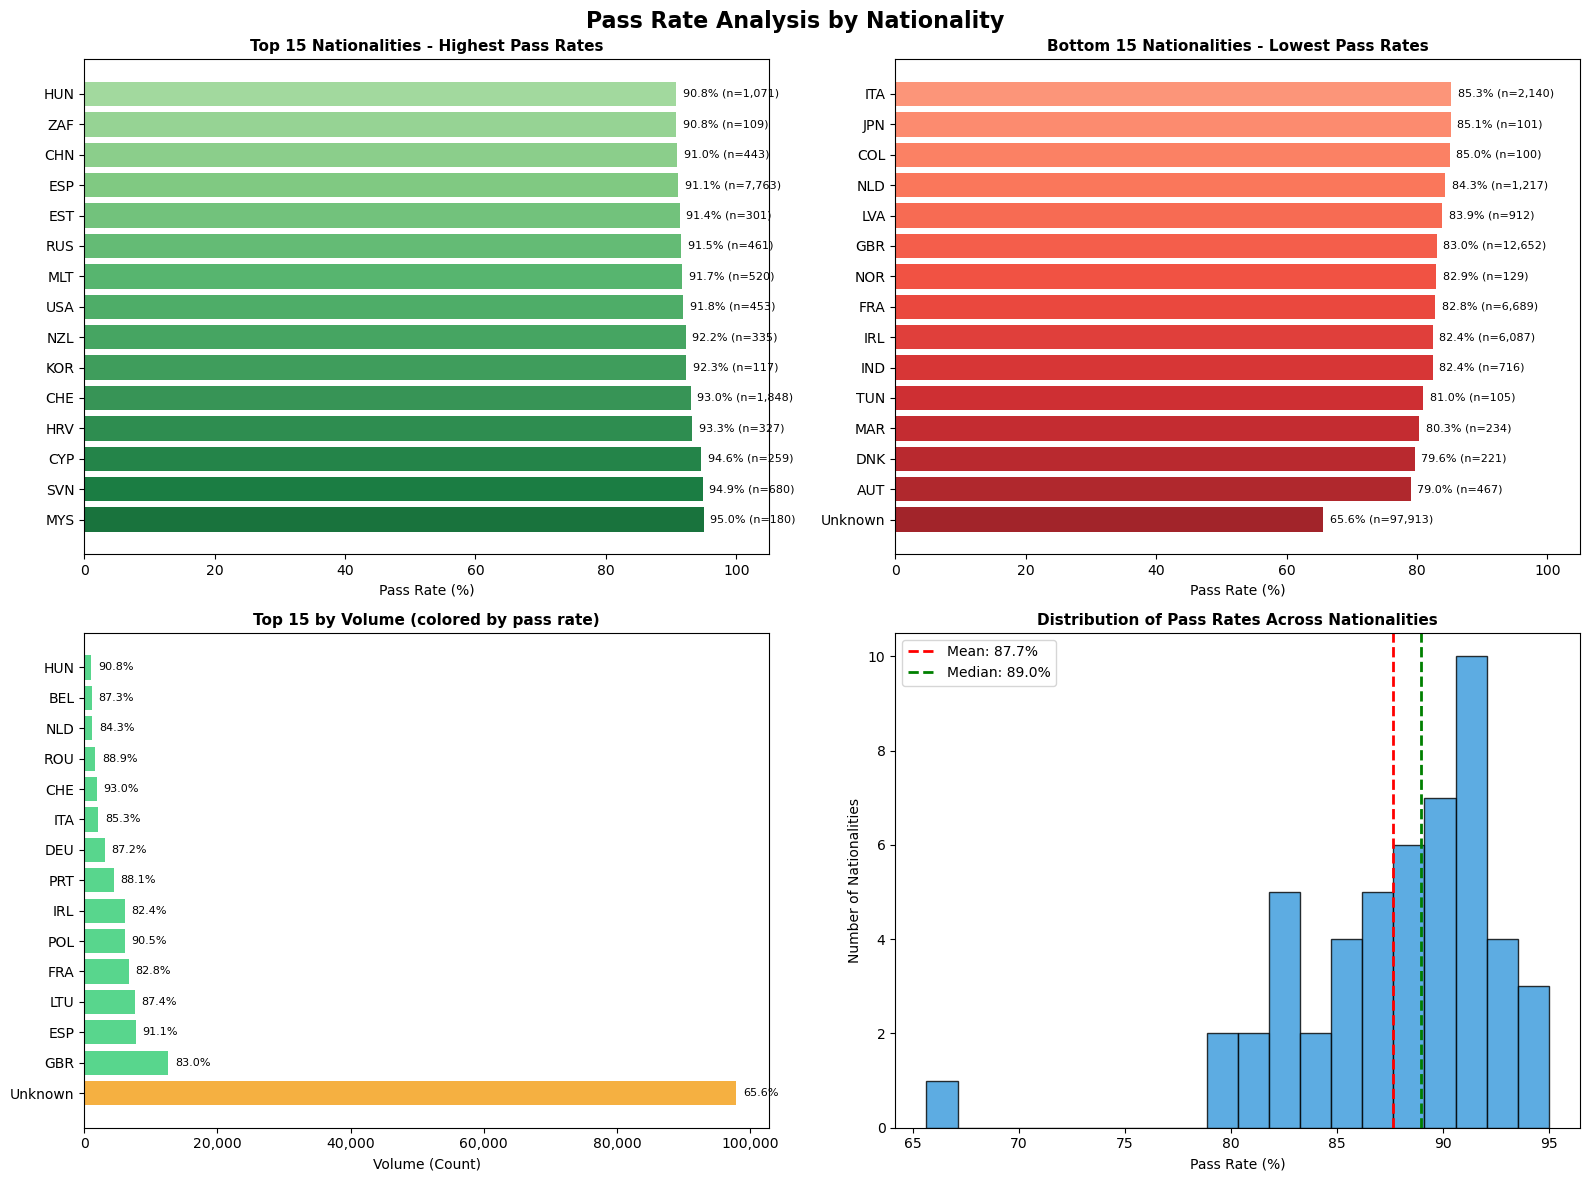


✅ Chart saved as 'pass_rate_by_nationality.png'


In [6]:
# Nationality Analysis (with minimum 100 samples for reliability)
nationality_stats = calculate_pass_rate(doc_check_df, 'nationality', min_samples=100)

print("=" * 80)
print("PASS RATE BY NATIONALITY (min 100 samples)")
print("=" * 80)

# Top 10 highest pass rates
print("\n🏆 TOP 10 HIGHEST PASS RATES:")
print(nationality_stats.head(10).to_string(index=False))

# Bottom 10 lowest pass rates
print("\n⚠️ BOTTOM 10 LOWEST PASS RATES:")
print(nationality_stats.tail(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pass Rate Analysis by Nationality', fontsize=16, fontweight='bold')

# Top 15 highest pass rates
ax1 = axes[0, 0]
top_15 = nationality_stats.head(15)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_15)))[::-1]
ax1.barh(top_15['nationality'], top_15['pass_rate'], color=colors, alpha=0.9)
ax1.set_xlabel('Pass Rate (%)', fontsize=10)
ax1.set_title('Top 15 Nationalities - Highest Pass Rates', fontsize=11, fontweight='bold')
ax1.set_xlim(0, 105)
for i, (rate, vol) in enumerate(zip(top_15['pass_rate'], top_15['total'])):
    ax1.text(rate + 1, i, f'{rate:.1f}% (n={vol:,})', va='center', fontsize=8)

# Bottom 15 lowest pass rates
ax2 = axes[0, 1]
bottom_15 = nationality_stats.tail(15).sort_values('pass_rate', ascending=True)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(bottom_15)))[::-1]
ax2.barh(bottom_15['nationality'], bottom_15['pass_rate'], color=colors, alpha=0.9)
ax2.set_xlabel('Pass Rate (%)', fontsize=10)
ax2.set_title('Bottom 15 Nationalities - Lowest Pass Rates', fontsize=11, fontweight='bold')
ax2.set_xlim(0, 105)
for i, (rate, vol) in enumerate(zip(bottom_15['pass_rate'], bottom_15['total'])):
    ax2.text(rate + 1, i, f'{rate:.1f}% (n={vol:,})', va='center', fontsize=8)

# Top 15 by volume
ax3 = axes[1, 0]
top_vol = nationality_stats.nlargest(15, 'total')
colors = ['#2ecc71' if x >= 80 else '#f39c12' if x >= 60 else '#e74c3c' for x in top_vol['pass_rate']]
ax3.barh(top_vol['nationality'], top_vol['total'], color=colors, alpha=0.8)
ax3.set_xlabel('Volume (Count)', fontsize=10)
ax3.set_title('Top 15 by Volume (colored by pass rate)', fontsize=11, fontweight='bold')
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
for i, (vol, rate) in enumerate(zip(top_vol['total'], top_vol['pass_rate'])):
    ax3.text(vol + max(top_vol['total'])*0.01, i, f'{rate:.1f}%', va='center', fontsize=8)

# Distribution histogram
ax4 = axes[1, 1]
ax4.hist(nationality_stats['pass_rate'], bins=20, color='#3498db', alpha=0.8, edgecolor='black')
ax4.axvline(x=nationality_stats['pass_rate'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {nationality_stats['pass_rate'].mean():.1f}%")
ax4.axvline(x=nationality_stats['pass_rate'].median(), color='green', linestyle='--', linewidth=2, 
            label=f"Median: {nationality_stats['pass_rate'].median():.1f}%")
ax4.set_xlabel('Pass Rate (%)', fontsize=10)
ax4.set_ylabel('Number of Nationalities', fontsize=10)
ax4.set_title('Distribution of Pass Rates Across Nationalities', fontsize=11, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig('pass_rate_by_nationality.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Chart saved as 'pass_rate_by_nationality.png'")

## 5. Pass Rate Analysis by Issuing Country

PASS RATE BY ISSUING COUNTRY (min 100 samples)

🏆 TOP 10 HIGHEST PASS RATES:
issuing_country  total  clear  consider  pass_rate  fail_rate
            JEY    300    291         9  97.000000   3.000000
            SGP    156    151         5  96.794872   3.205128
            SVN    940    895        45  95.212766   4.787234
            CHE   2873   2712       161  94.396102   5.603898
            MYS    181    170        11  93.922652   6.077348
            HRV    351    328        23  93.447293   6.552707
            NZL    466    435        31  93.347639   6.652361
            RUS    387    361        26  93.281654   6.718346
            CYP    747    696        51  93.172691   6.827309
            MLT    715    663        52  92.727273   7.272727

⚠️ BOTTOM 10 LOWEST PASS RATES:
issuing_country  total  clear  consider  pass_rate  fail_rate
            LVA   1252   1082       170  86.421725  13.578275
            BEL   1597   1380       217  86.412023  13.587977
            MEX    105

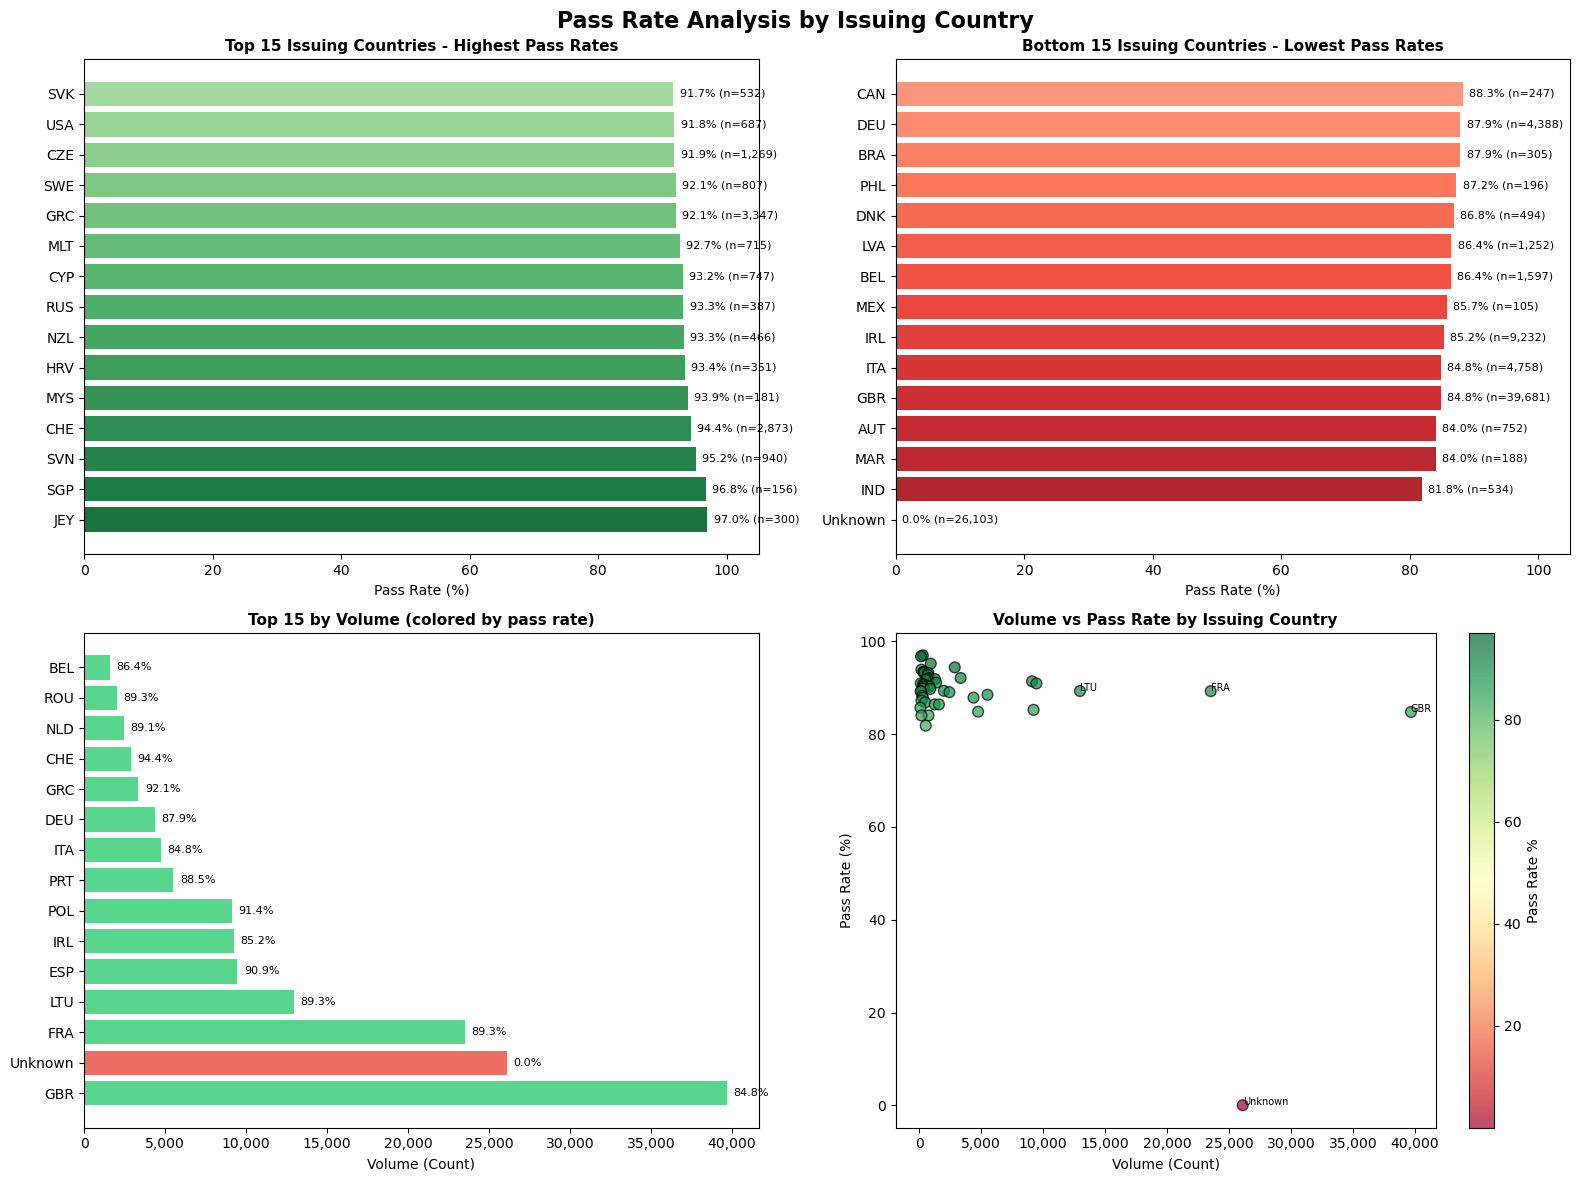


✅ Chart saved as 'pass_rate_by_issuing_country.png'


In [7]:
# Issuing Country Analysis
country_stats = calculate_pass_rate(doc_check_df, 'issuing_country', min_samples=100)

print("=" * 80)
print("PASS RATE BY ISSUING COUNTRY (min 100 samples)")
print("=" * 80)

print("\n🏆 TOP 10 HIGHEST PASS RATES:")
print(country_stats.head(10).to_string(index=False))

print("\n⚠️ BOTTOM 10 LOWEST PASS RATES:")
print(country_stats.tail(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pass Rate Analysis by Issuing Country', fontsize=16, fontweight='bold')

# Top 15 highest pass rates
ax1 = axes[0, 0]
top_15 = country_stats.head(15)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_15)))[::-1]
ax1.barh(top_15['issuing_country'], top_15['pass_rate'], color=colors, alpha=0.9)
ax1.set_xlabel('Pass Rate (%)', fontsize=10)
ax1.set_title('Top 15 Issuing Countries - Highest Pass Rates', fontsize=11, fontweight='bold')
ax1.set_xlim(0, 105)
for i, (rate, vol) in enumerate(zip(top_15['pass_rate'], top_15['total'])):
    ax1.text(rate + 1, i, f'{rate:.1f}% (n={vol:,})', va='center', fontsize=8)

# Bottom 15 lowest pass rates
ax2 = axes[0, 1]
bottom_15 = country_stats.tail(15).sort_values('pass_rate', ascending=True)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(bottom_15)))[::-1]
ax2.barh(bottom_15['issuing_country'], bottom_15['pass_rate'], color=colors, alpha=0.9)
ax2.set_xlabel('Pass Rate (%)', fontsize=10)
ax2.set_title('Bottom 15 Issuing Countries - Lowest Pass Rates', fontsize=11, fontweight='bold')
ax2.set_xlim(0, 105)
for i, (rate, vol) in enumerate(zip(bottom_15['pass_rate'], bottom_15['total'])):
    ax2.text(rate + 1, i, f'{rate:.1f}% (n={vol:,})', va='center', fontsize=8)

# Top 15 by volume
ax3 = axes[1, 0]
top_vol = country_stats.nlargest(15, 'total')
colors = ['#2ecc71' if x >= 80 else '#f39c12' if x >= 60 else '#e74c3c' for x in top_vol['pass_rate']]
ax3.barh(top_vol['issuing_country'], top_vol['total'], color=colors, alpha=0.8)
ax3.set_xlabel('Volume (Count)', fontsize=10)
ax3.set_title('Top 15 by Volume (colored by pass rate)', fontsize=11, fontweight='bold')
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
for i, (vol, rate) in enumerate(zip(top_vol['total'], top_vol['pass_rate'])):
    ax3.text(vol + max(top_vol['total'])*0.01, i, f'{rate:.1f}%', va='center', fontsize=8)

# Scatter: Volume vs Pass Rate
ax4 = axes[1, 1]
scatter = ax4.scatter(country_stats['total'], country_stats['pass_rate'], 
                       c=country_stats['pass_rate'], cmap='RdYlGn', s=60, alpha=0.7, edgecolors='black')
ax4.set_xlabel('Volume (Count)', fontsize=10)
ax4.set_ylabel('Pass Rate (%)', fontsize=10)
ax4.set_title('Volume vs Pass Rate by Issuing Country', fontsize=11, fontweight='bold')
ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.colorbar(scatter, ax=ax4, label='Pass Rate %')

# Annotate outliers
for idx, row in country_stats.iterrows():
    if row['pass_rate'] < 60 or row['total'] > 10000:
        ax4.annotate(row['issuing_country'], (row['total'], row['pass_rate']), fontsize=7)

plt.tight_layout()
plt.savefig('pass_rate_by_issuing_country.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Chart saved as 'pass_rate_by_issuing_country.png'")

## 6. Cross Analysis: Document Type × Issuing Country

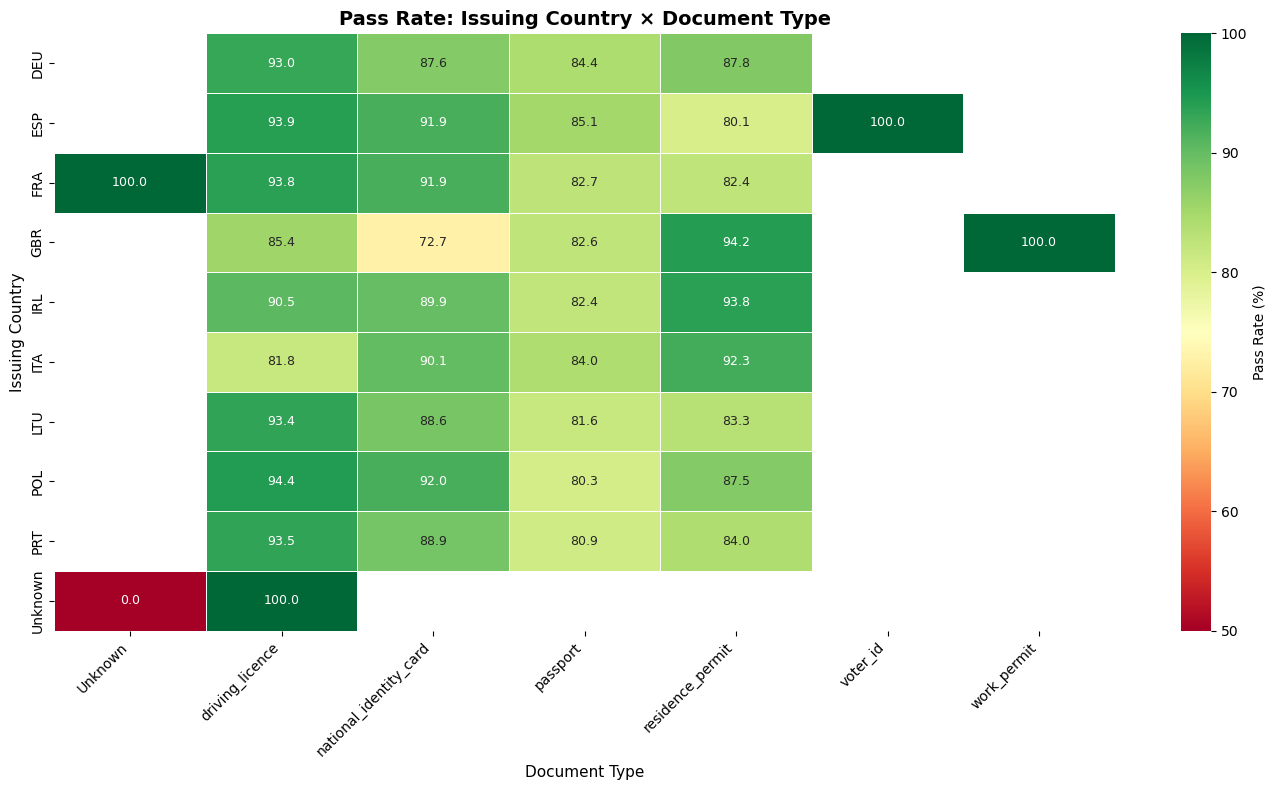

✅ Chart saved as 'cross_analysis_country_doctype.png'


In [8]:
# Cross analysis: Document Type by Issuing Country (for top countries)
top_countries = country_stats.nlargest(10, 'total')['issuing_country'].tolist()
cross_df = doc_check_df[doc_check_df['issuing_country'].isin(top_countries)]

# Calculate pass rate for each combination
cross_stats = cross_df.groupby(['issuing_country', 'document_type']).agg(
    total=('result', 'count'),
    clear=('result', lambda x: (x == 'clear').sum())
).reset_index()
cross_stats['pass_rate'] = (cross_stats['clear'] / cross_stats['total']) * 100

# Pivot for heatmap
pivot_table = cross_stats.pivot(index='issuing_country', columns='document_type', values='pass_rate')

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
mask = pivot_table.isna()
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn', center=75, 
            ax=ax, mask=mask, linewidths=0.5, annot_kws={'size': 9},
            vmin=50, vmax=100, cbar_kws={'label': 'Pass Rate (%)'})

ax.set_title('Pass Rate: Issuing Country × Document Type', fontsize=14, fontweight='bold')
ax.set_xlabel('Document Type', fontsize=11)
ax.set_ylabel('Issuing Country', fontsize=11)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('cross_analysis_country_doctype.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'cross_analysis_country_doctype.png'")

## 7. Pass Rate Trends Over Time by Property

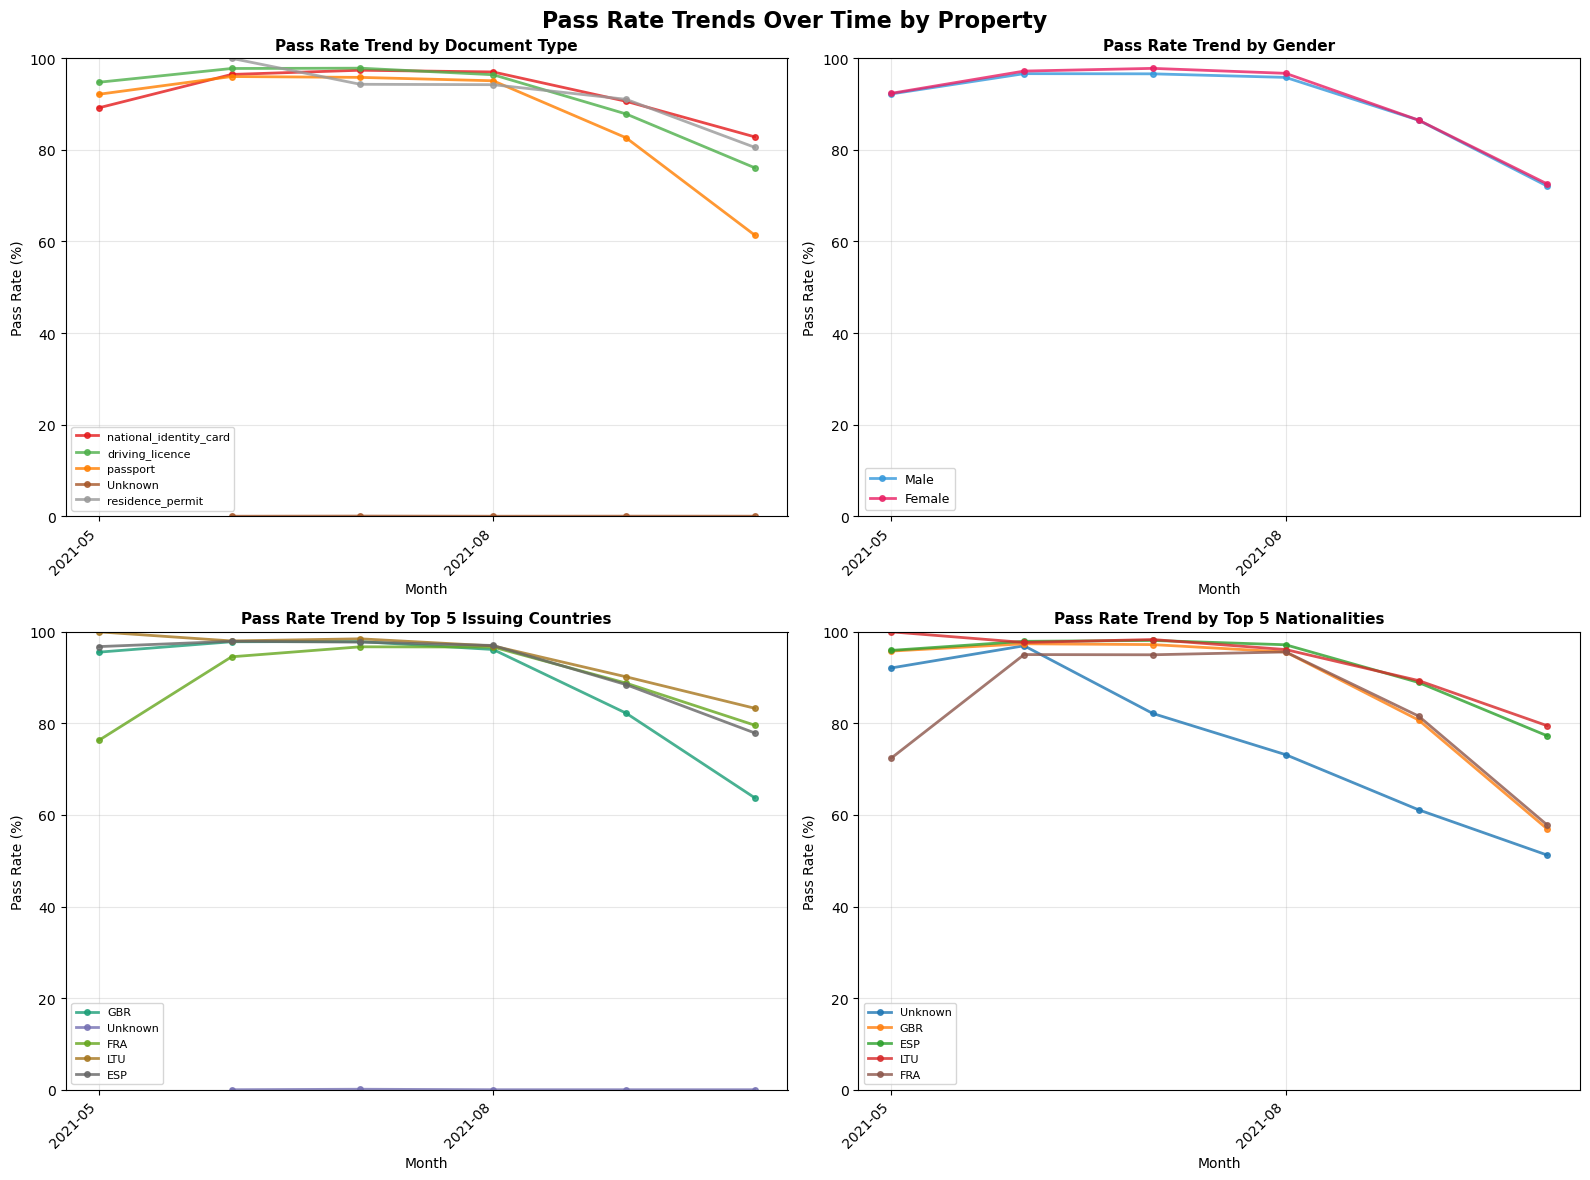

✅ Chart saved as 'pass_rate_trends_by_property.png'


In [9]:
# Pass rate trends over time by Document Type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pass Rate Trends Over Time by Property', fontsize=16, fontweight='bold')

# By Document Type
ax1 = axes[0, 0]
doc_types = doc_check_df['document_type'].value_counts().head(5).index.tolist()
colors = plt.cm.Set1(np.linspace(0, 1, len(doc_types)))

for idx, doc_type in enumerate(doc_types):
    df_subset = doc_check_df[doc_check_df['document_type'] == doc_type]
    monthly = df_subset.groupby('year_month').agg(
        total=('result', 'count'),
        clear=('result', lambda x: (x == 'clear').sum())
    ).reset_index()
    monthly['pass_rate'] = (monthly['clear'] / monthly['total']) * 100
    monthly['year_month_dt'] = monthly['year_month'].dt.to_timestamp()
    
    ax1.plot(monthly['year_month_dt'], monthly['pass_rate'], marker='o', linewidth=2, 
             color=colors[idx], markersize=4, label=doc_type, alpha=0.8)

ax1.set_title('Pass Rate Trend by Document Type', fontsize=11, fontweight='bold')
ax1.set_xlabel('Month', fontsize=10)
ax1.set_ylabel('Pass Rate (%)', fontsize=10)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower left', fontsize=8)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# By Gender
ax2 = axes[0, 1]
genders = ['Male', 'Female']
colors_gender = ['#3498db', '#e91e63']

for idx, gender in enumerate(genders):
    df_subset = doc_check_df[doc_check_df['gender'] == gender]
    monthly = df_subset.groupby('year_month').agg(
        total=('result', 'count'),
        clear=('result', lambda x: (x == 'clear').sum())
    ).reset_index()
    monthly['pass_rate'] = (monthly['clear'] / monthly['total']) * 100
    monthly['year_month_dt'] = monthly['year_month'].dt.to_timestamp()
    
    ax2.plot(monthly['year_month_dt'], monthly['pass_rate'], marker='o', linewidth=2, 
             color=colors_gender[idx], markersize=4, label=gender, alpha=0.8)

ax2.set_title('Pass Rate Trend by Gender', fontsize=11, fontweight='bold')
ax2.set_xlabel('Month', fontsize=10)
ax2.set_ylabel('Pass Rate (%)', fontsize=10)
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower left', fontsize=9)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# By Top 5 Issuing Countries
ax3 = axes[1, 0]
top_5_countries = country_stats.nlargest(5, 'total')['issuing_country'].tolist()
colors_country = plt.cm.Dark2(np.linspace(0, 1, len(top_5_countries)))

for idx, country in enumerate(top_5_countries):
    df_subset = doc_check_df[doc_check_df['issuing_country'] == country]
    monthly = df_subset.groupby('year_month').agg(
        total=('result', 'count'),
        clear=('result', lambda x: (x == 'clear').sum())
    ).reset_index()
    monthly['pass_rate'] = (monthly['clear'] / monthly['total']) * 100
    monthly['year_month_dt'] = monthly['year_month'].dt.to_timestamp()
    
    ax3.plot(monthly['year_month_dt'], monthly['pass_rate'], marker='o', linewidth=2, 
             color=colors_country[idx], markersize=4, label=country, alpha=0.8)

ax3.set_title('Pass Rate Trend by Top 5 Issuing Countries', fontsize=11, fontweight='bold')
ax3.set_xlabel('Month', fontsize=10)
ax3.set_ylabel('Pass Rate (%)', fontsize=10)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='lower left', fontsize=8)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# By Top 5 Nationalities
ax4 = axes[1, 1]
top_5_nat = nationality_stats.nlargest(5, 'total')['nationality'].tolist()
colors_nat = plt.cm.tab10(np.linspace(0, 0.5, len(top_5_nat)))

for idx, nat in enumerate(top_5_nat):
    df_subset = doc_check_df[doc_check_df['nationality'] == nat]
    monthly = df_subset.groupby('year_month').agg(
        total=('result', 'count'),
        clear=('result', lambda x: (x == 'clear').sum())
    ).reset_index()
    monthly['pass_rate'] = (monthly['clear'] / monthly['total']) * 100
    monthly['year_month_dt'] = monthly['year_month'].dt.to_timestamp()
    
    ax4.plot(monthly['year_month_dt'], monthly['pass_rate'], marker='o', linewidth=2, 
             color=colors_nat[idx], markersize=4, label=nat, alpha=0.8)

ax4.set_title('Pass Rate Trend by Top 5 Nationalities', fontsize=11, fontweight='bold')
ax4.set_xlabel('Month', fontsize=10)
ax4.set_ylabel('Pass Rate (%)', fontsize=10)
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3)
ax4.legend(loc='lower left', fontsize=8)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('pass_rate_trends_by_property.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'pass_rate_trends_by_property.png'")

## 8. Sub-Result Analysis by Properties

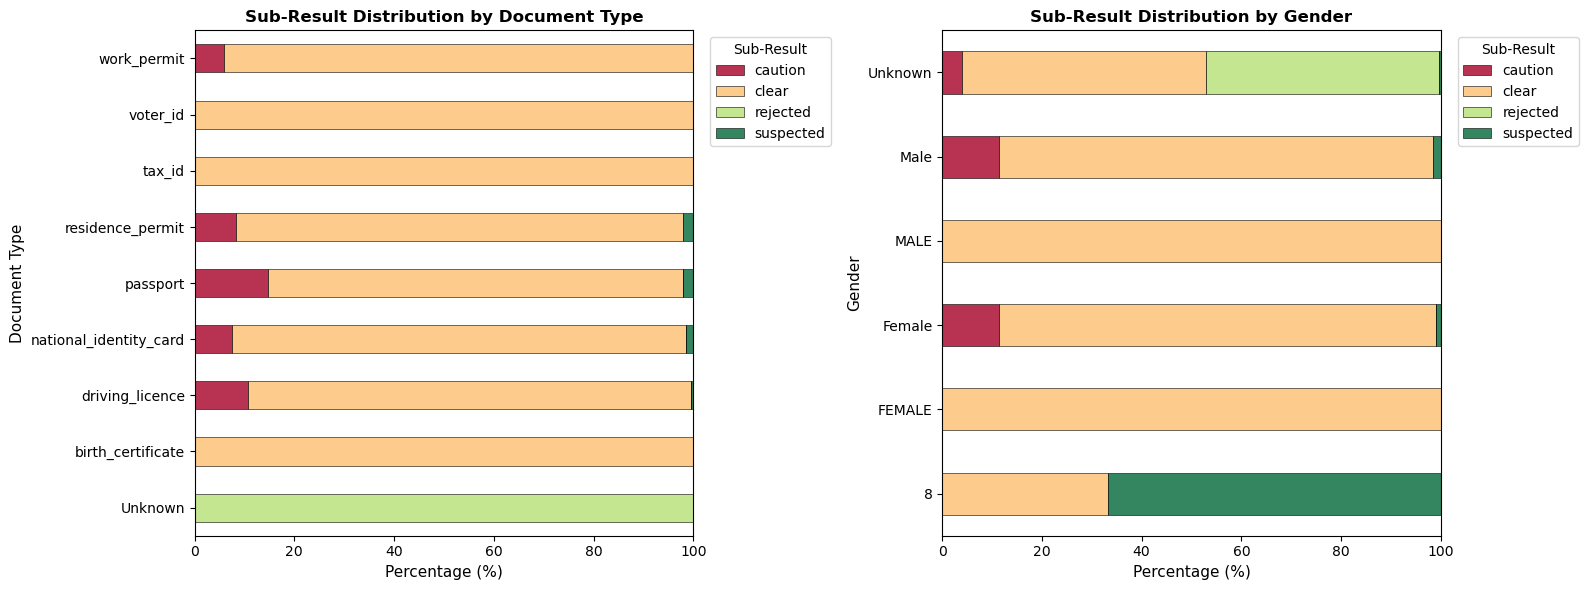

✅ Chart saved as 'subresult_by_properties.png'


In [10]:
# Sub-result distribution by document type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sub-result distribution by document type
ax1 = axes[0]
sub_by_doc = doc_check_df.groupby(['document_type', 'sub_result']).size().unstack(fill_value=0)
sub_by_doc_pct = sub_by_doc.div(sub_by_doc.sum(axis=1), axis=0) * 100
sub_by_doc_pct.plot(kind='barh', stacked=True, ax=ax1, 
                     colormap='RdYlGn', alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Percentage (%)', fontsize=11)
ax1.set_ylabel('Document Type', fontsize=11)
ax1.set_title('Sub-Result Distribution by Document Type', fontsize=12, fontweight='bold')
ax1.legend(title='Sub-Result', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.set_xlim(0, 100)

# Sub-result distribution by gender
ax2 = axes[1]
sub_by_gender = doc_check_df.groupby(['gender', 'sub_result']).size().unstack(fill_value=0)
sub_by_gender_pct = sub_by_gender.div(sub_by_gender.sum(axis=1), axis=0) * 100
sub_by_gender_pct.plot(kind='barh', stacked=True, ax=ax2, 
                        colormap='RdYlGn', alpha=0.8, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Percentage (%)', fontsize=11)
ax2.set_ylabel('Gender', fontsize=11)
ax2.set_title('Sub-Result Distribution by Gender', fontsize=12, fontweight='bold')
ax2.legend(title='Sub-Result', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('subresult_by_properties.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved as 'subresult_by_properties.png'")

## 9. Summary Dashboard

In [11]:
# Comprehensive Summary Statistics
print("=" * 100)
print("PROPERTIES ANALYSIS - COMPREHENSIVE SUMMARY")
print("=" * 100)

# Overall stats
overall_pass_rate = (doc_check_df['result'] == 'clear').mean() * 100
print(f"\n📊 OVERALL PASS RATE: {overall_pass_rate:.2f}%")
print(f"   Total Records: {len(doc_check_df):,}")

# Document Type Summary
print("\n" + "-" * 50)
print("📄 DOCUMENT TYPE SUMMARY")
print("-" * 50)
for _, row in doc_type_stats.iterrows():
    status = "✅" if row['pass_rate'] >= overall_pass_rate else "⚠️"
    print(f"{status} {row['document_type']}: {row['pass_rate']:.1f}% (n={row['total']:,})")

# Gender Summary
print("\n" + "-" * 50)
print("👤 GENDER SUMMARY")
print("-" * 50)
for _, row in gender_stats.iterrows():
    status = "✅" if row['pass_rate'] >= overall_pass_rate else "⚠️"
    print(f"{status} {row['gender']}: {row['pass_rate']:.1f}% (n={row['total']:,})")

# Top/Bottom Nationalities
print("\n" + "-" * 50)
print("🌍 NATIONALITY INSIGHTS")
print("-" * 50)
print(f"   Highest: {nationality_stats.iloc[0]['nationality']} ({nationality_stats.iloc[0]['pass_rate']:.1f}%)")
print(f"   Lowest: {nationality_stats.iloc[-1]['nationality']} ({nationality_stats.iloc[-1]['pass_rate']:.1f}%)")
print(f"   Average across nationalities: {nationality_stats['pass_rate'].mean():.1f}%")
print(f"   Std Dev: {nationality_stats['pass_rate'].std():.1f}%")

# Top/Bottom Countries
print("\n" + "-" * 50)
print("🏳️ ISSUING COUNTRY INSIGHTS")
print("-" * 50)
print(f"   Highest: {country_stats.iloc[0]['issuing_country']} ({country_stats.iloc[0]['pass_rate']:.1f}%)")
print(f"   Lowest: {country_stats.iloc[-1]['issuing_country']} ({country_stats.iloc[-1]['pass_rate']:.1f}%)")
print(f"   Average across countries: {country_stats['pass_rate'].mean():.1f}%")

print("\n" + "=" * 100)

PROPERTIES ANALYSIS - COMPREHENSIVE SUMMARY

📊 OVERALL PASS RATE: 75.06%
   Total Records: 176,404

--------------------------------------------------
📄 DOCUMENT TYPE SUMMARY
--------------------------------------------------
✅ national_identity_card: 91.1% (n=54,613)
✅ residence_permit: 89.5% (n=2,929)
✅ driving_licence: 88.9% (n=50,492)
✅ passport: 83.2% (n=42,228)
⚠️ Unknown: 0.0% (n=26,106)

--------------------------------------------------
👤 GENDER SUMMARY
--------------------------------------------------
✅ Female: 87.5% (n=41,536)
✅ Male: 87.0% (n=78,397)
⚠️ Unknown: 49.0% (n=55,836)

--------------------------------------------------
🌍 NATIONALITY INSIGHTS
--------------------------------------------------
   Highest: MYS (95.0%)
   Lowest: Unknown (65.6%)
   Average across nationalities: 87.7%
   Std Dev: 5.1%

--------------------------------------------------
🏳️ ISSUING COUNTRY INSIGHTS
--------------------------------------------------
   Highest: JEY (97.0%)
   Lowest: Un

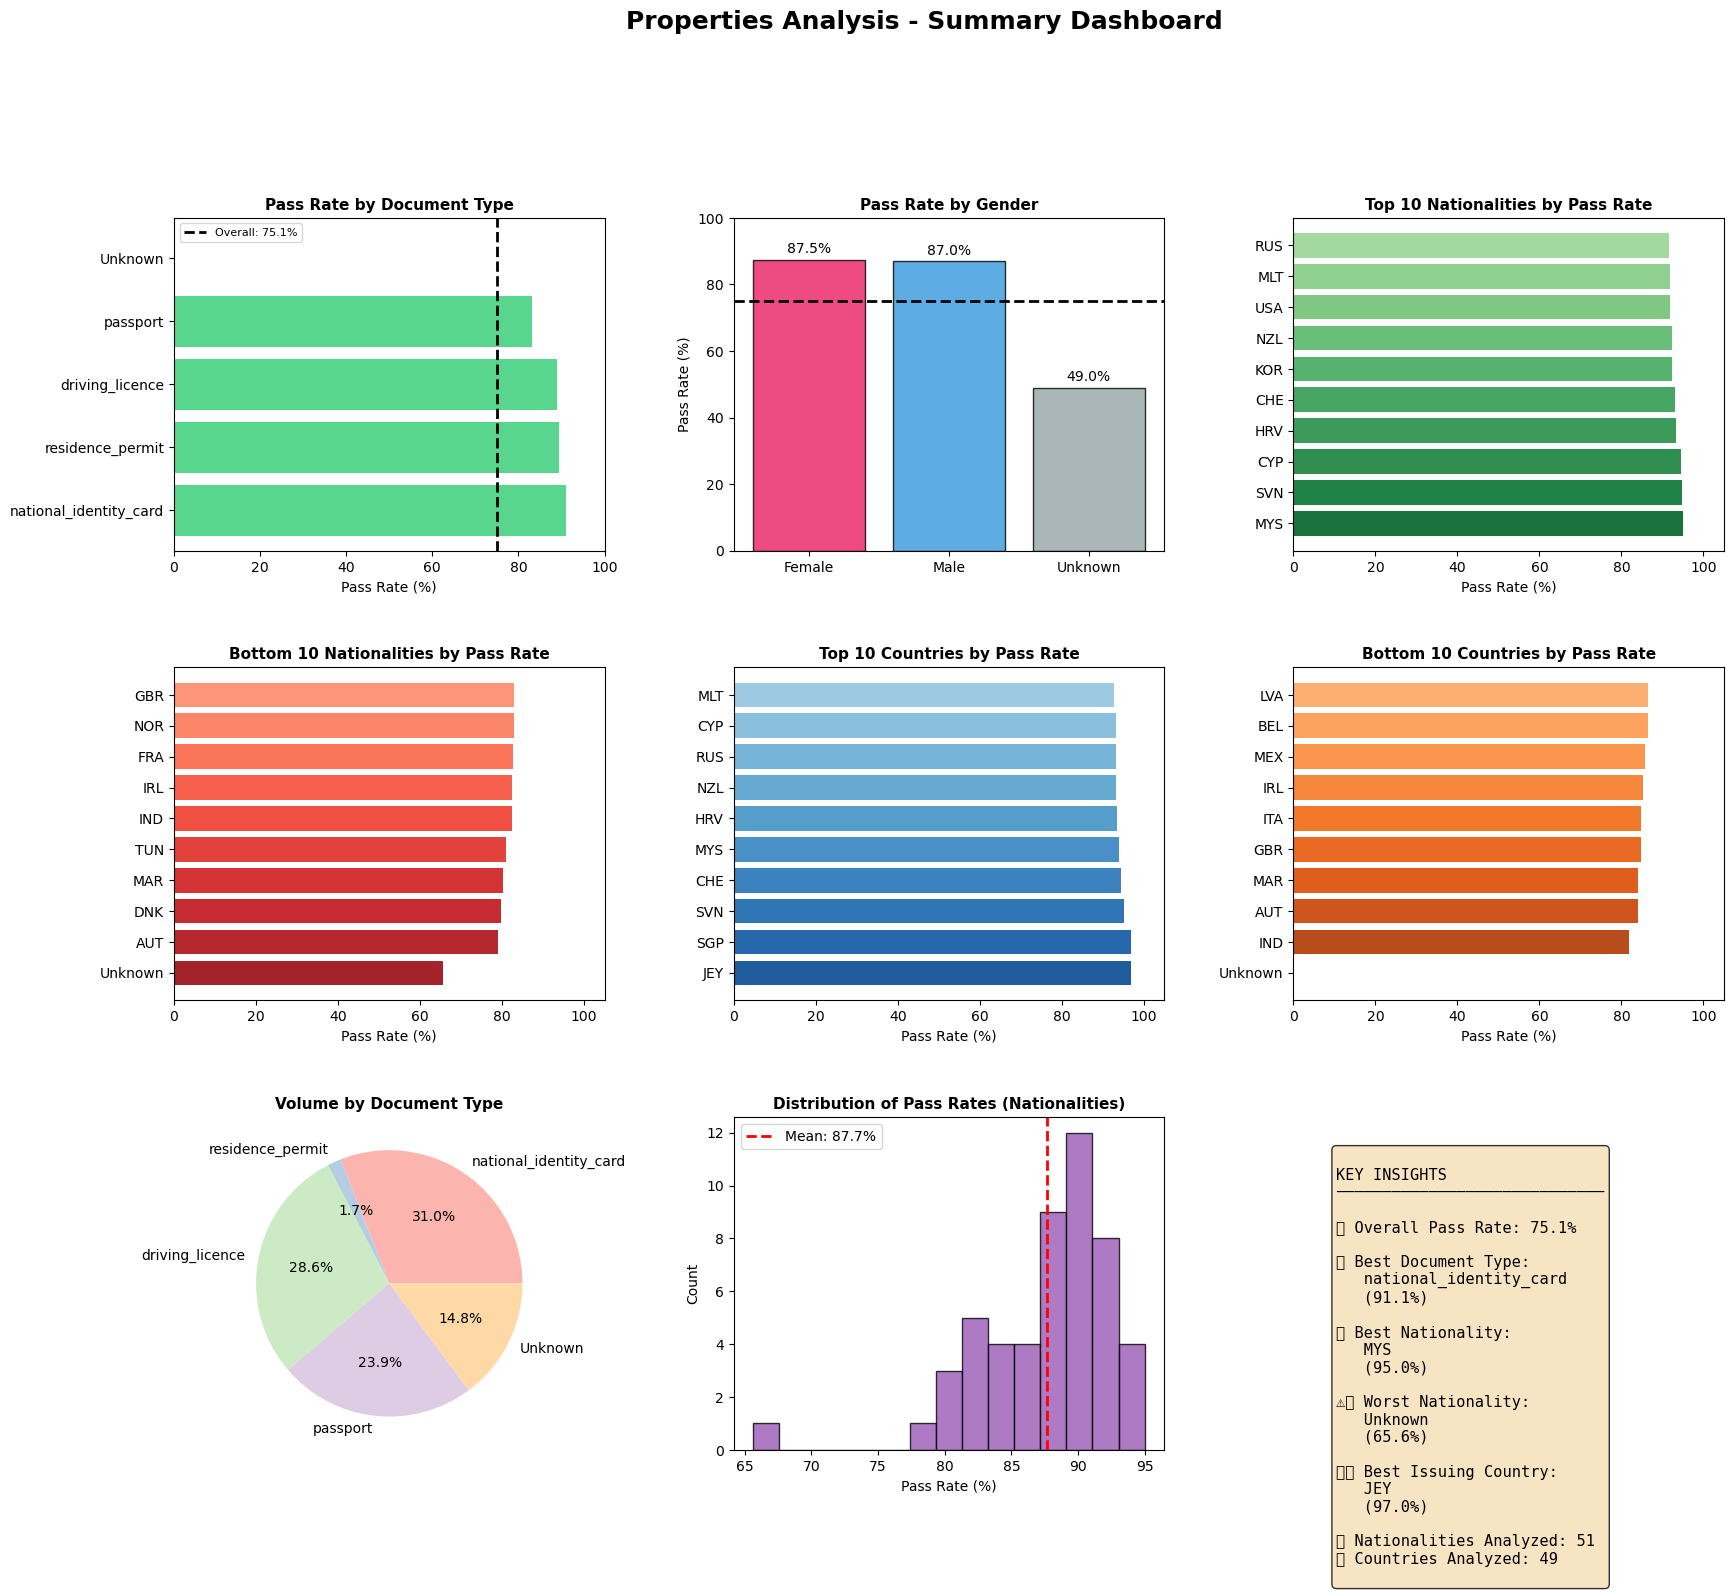


✅ Dashboard saved as 'properties_summary_dashboard.png'


In [ ]:
# Final Summary Dashboard
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Document Type Pass Rates
ax1 = fig.add_subplot(gs[0, 0])
colors = ['#2ecc71' if x >= overall_pass_rate else '#e74c3c' for x in doc_type_stats['pass_rate']]
ax1.barh(doc_type_stats['document_type'], doc_type_stats['pass_rate'], color=colors, alpha=0.8)
ax1.axvline(x=overall_pass_rate, color='black', linestyle='--', linewidth=2, label=f'Overall: {overall_pass_rate:.1f}%')
ax1.set_xlabel('Pass Rate (%)', fontsize=10)
ax1.set_title('Pass Rate by Document Type', fontsize=11, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.legend(fontsize=8)

# 2. Gender Pass Rates
ax2 = fig.add_subplot(gs[0, 1])
colors_g = ['#3498db' if g == 'Male' else '#e91e63' if g == 'Female' else '#95a5a6' for g in gender_stats['gender']]
bars = ax2.bar(gender_stats['gender'], gender_stats['pass_rate'], color=colors_g, alpha=0.8, edgecolor='black')
ax2.axhline(y=overall_pass_rate, color='black', linestyle='--', linewidth=2)
ax2.set_ylabel('Pass Rate (%)', fontsize=10)
ax2.set_title('Pass Rate by Gender', fontsize=11, fontweight='bold')
ax2.set_ylim(0, 100)
for bar, rate in zip(bars, gender_stats['pass_rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, rate + 2, f'{rate:.1f}%', ha='center', fontsize=10)

# 3. Top 10 Nationalities
ax3 = fig.add_subplot(gs[0, 2])
top_10_nat = nationality_stats.head(10)
colors_nat = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_10_nat)))[::-1]
ax3.barh(top_10_nat['nationality'], top_10_nat['pass_rate'], color=colors_nat, alpha=0.9)
ax3.set_xlabel('Pass Rate (%)', fontsize=10)
ax3.set_title('Top 10 Nationalities by Pass Rate', fontsize=11, fontweight='bold')
ax3.set_xlim(0, 105)

# 4. Bottom 10 Nationalities
ax4 = fig.add_subplot(gs[1, 0])
bottom_10_nat = nationality_stats.tail(10).sort_values('pass_rate', ascending=True)
colors_nat = plt.cm.Reds(np.linspace(0.4, 0.9, len(bottom_10_nat)))[::-1]
ax4.barh(bottom_10_nat['nationality'], bottom_10_nat['pass_rate'], color=colors_nat, alpha=0.9)
ax4.set_xlabel('Pass Rate (%)', fontsize=10)
ax4.set_title('Bottom 10 Nationalities by Pass Rate', fontsize=11, fontweight='bold')
ax4.set_xlim(0, 105)

# 5. Top 10 Issuing Countries
ax5 = fig.add_subplot(gs[1, 1])
top_10_c = country_stats.head(10)
colors_c = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_10_c)))[::-1]
ax5.barh(top_10_c['issuing_country'], top_10_c['pass_rate'], color=colors_c, alpha=0.9)
ax5.set_xlabel('Pass Rate (%)', fontsize=10)
ax5.set_title('Top 10 Countries by Pass Rate', fontsize=11, fontweight='bold')
ax5.set_xlim(0, 105)

# 6. Bottom 10 Issuing Countries
ax6 = fig.add_subplot(gs[1, 2])
bottom_10_c = country_stats.tail(10).sort_values('pass_rate', ascending=True)
colors_c = plt.cm.Oranges(np.linspace(0.4, 0.9, len(bottom_10_c)))[::-1]
ax6.barh(bottom_10_c['issuing_country'], bottom_10_c['pass_rate'], color=colors_c, alpha=0.9)
ax6.set_xlabel('Pass Rate (%)', fontsize=10)
ax6.set_title('Bottom 10 Countries by Pass Rate', fontsize=11, fontweight='bold')
ax6.set_xlim(0, 105)

# 7. Volume Distribution (pie)
ax7 = fig.add_subplot(gs[2, 0])
doc_type_vol = doc_type_stats.set_index('document_type')['total']
ax7.pie(doc_type_vol, labels=doc_type_vol.index, autopct='%1.1f%%', colors=plt.cm.Pastel1.colors)
ax7.set_title('Volume by Document Type', fontsize=11, fontweight='bold')

# 8. Pass Rate Distribution (histogram)
ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(nationality_stats['pass_rate'], bins=15, color='#9b59b6', alpha=0.8, edgecolor='black')
ax8.axvline(x=nationality_stats['pass_rate'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {nationality_stats["pass_rate"].mean():.1f}%')
ax8.set_xlabel('Pass Rate (%)', fontsize=10)
ax8.set_ylabel('Count', fontsize=10)
ax8.set_title('Distribution of Pass Rates (Nationalities)', fontsize=11, fontweight='bold')
ax8.legend()

# 9. Key Metrics Text
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
text_summary = f"""
KEY INSIGHTS
─────────────────────────────

📊 Overall Pass Rate: {overall_pass_rate:.1f}%

📄 Best Document Type:
   {doc_type_stats.iloc[0]['document_type']}
   ({doc_type_stats.iloc[0]['pass_rate']:.1f}%)

🌍 Best Nationality:
   {nationality_stats.iloc[0]['nationality']}
   ({nationality_stats.iloc[0]['pass_rate']:.1f}%)

⚠️ Worst Nationality:
   {nationality_stats.iloc[-1]['nationality']}
   ({nationality_stats.iloc[-1]['pass_rate']:.1f}%)

🏳️ Best Issuing Country:
   {country_stats.iloc[0]['issuing_country']}
   ({country_stats.iloc[0]['pass_rate']:.1f}%)

📈 Nationalities Analyzed: {len(nationality_stats)}
📈 Countries Analyzed: {len(country_stats)}
"""
ax9.text(0.1, 0.9, text_summary, transform=ax9.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

fig.suptitle('Properties Analysis - Summary Dashboard', fontsize=18, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('properties_summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ Dashboard saved as 'properties_summary_dashboard.png'")